## Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

In [3]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

# gcs = pd.read_csv('data/patient_motor.csv')
# gcs = gcs[gcs['observationoffset'] > -1]
# gcs['observationoffset'] = gcs['observationoffset'] / 60


#display(hr)
#display(resp)
#display(sao2)

In [9]:
# Demographics, anything from first 24 hours
# Extract full first 24 hours and then summarize in smaller number of features (constant number of features per patient)

# Get a list of mortality/final gcs and see if there is a significant difference 
#   between these variables for either case

# For respiratory data, use an indicator variable for whether there was a
#   measurement recorded
#   - or, number of measurements in the first day might be useful depending on whether
#     respiratory data is collected automatically

# # Loading patient IDs
# patients = pd.DataFrame(np.load('TeamAlpacaPatients.npy'))
# # patients.head()
# print("loaded patients")

# # Loading nursecharting data
# nursecharting = pd.read_csv('data/nursecharting_data.csv')
# print("loaded nursecharting")

# Loading demographic data
demographic = pd.read_csv('data/patient_demographics_data.csv')
print("loaded demographic")

# # Loading physiology data
# physiology = pd.read_csv('data/physiology_data.csv')
# print("loaded physiology")

# # Loading apache data
# apache = pd.read_csv('data/apache_pred_data.csv')
# print("loaded apache")

# # Loading lab data
# lab = pd.read_csv('data/lab_data.csv')
# print("loaded lab")

# # Loading respiratory data
# respiratory = pd.read_csv('data/respiratory_data_long_query.csv')
# print("loaded respiratory")

# # Loading medication data
# medication = pd.read_csv('data/medication_data_long_query.csv')
# print("loaded medication")

# # Loading infusion data
# infusion = pd.read_csv('data/infusion_data_long_query.csv')
# print("loaded infusion")

loaded demographic


In [7]:
patients = patients.rename(columns={0: "patientunitstayid"})
# patients.head()

In [10]:
demographic_sub = demographic.merge(patients, on='patientunitstayid').drop_duplicates(subset='patientunitstayid')
mortality = demographic_sub[['patientunitstayid','hospitaldischargestatus']]

## Apache

[0.8173803526448362, 0.8664516129032258]
[0.18261964735516373, 0.1335483870967742]


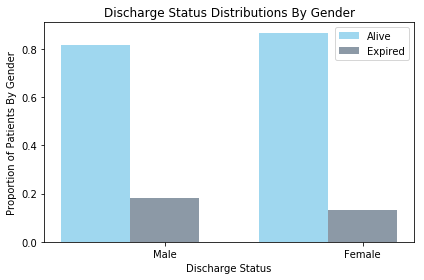

In [179]:
# Finding distributions for mortality for the apache features
# for col in apache.columns:
#     print(col)
    
# GCS: motor, eye, verbal, total
# Merging mortality with apache
apache_merged = mortality.merge(apache, on='patientunitstayid')
apache_merged.head()
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].plot(kind='bar')
grouped = apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].drop(labels=-1, level=1)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = 2
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Discharge Status')
plt.ylabel('Proportion of Patients By Gender')
plt.title('Discharge Status Distributions By Gender')
plt.xticks(index + bar_width, ('Male', 'Female'))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

[0.7600251019767806, 0.8976744186046511, 0.9235245220282626, 0.8914830647813219, 0.9448209099709584]
[0.23997489802321934, 0.10232558139534884, 0.07647547797173733, 0.10851693521867807, 0.05517909002904162]


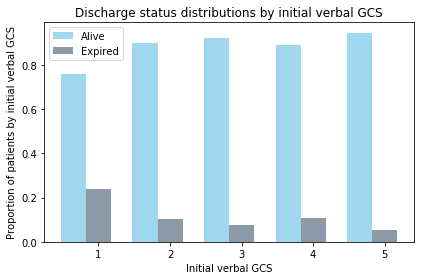

In [176]:
# Finding distributions for mortality for the apache features
# for col in apache.columns:
#     print(col)
    
# GCS: motor, eye, verbal, total
# Merging mortality with apache
apache_merged = mortality.merge(apache, on='patientunitstayid')
apache_merged.head()
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].plot(kind='bar')
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].drop(labels=-1, level=1)

gcs_type = 'verbal'
gcs_max = 5

grouped = apache_merged.groupby(['hospitaldischargestatus', gcs_type]).count()['patientunitstayid'].drop(labels=-1, level=1)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = gcs_max
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Initial ' + gcs_type + ' GCS')
plt.ylabel('Proportion of patients by initial ' + gcs_type + ' GCS')
plt.title('Discharge status distributions by initial ' + gcs_type + ' GCS')
plt.xticks(index + bar_width, tuple(list(range(1,gcs_max+1))))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

hospitaldischargestatus  oobintubday1
Alive                    0                7986
                         1               15104
Expired                  0                 625
                         1                4043
Name: patientunitstayid, dtype: int64
[625, 4043, 0, 0]
[0.9274184183021716, 0.7888442053585418]
[0.07258158169782836, 0.2111557946414582]


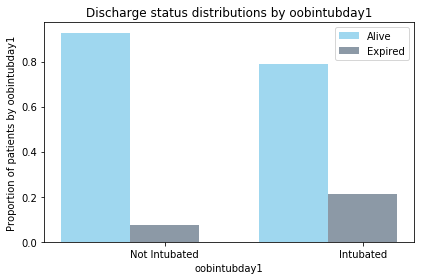

In [350]:
# Finding distributions for mortality for the apache features
# for col in apache.columns:
#     print(col)
    
# GCS: motor, eye, verbal, total
# Merging mortality with apache
apache_merged = mortality.merge(apache, on='patientunitstayid')
apache_merged.head()
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].plot(kind='bar')
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].drop(labels=-1, level=1)

gcs_type = 'oobintubday1'
gcs_max = 2

grouped = apache_merged.groupby(['hospitaldischargestatus', gcs_type]).count()['patientunitstayid'].drop(labels=-1, level=1)
print(grouped)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])
exp.insert(2,0)
exp.insert(4,0)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = gcs_max
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel(gcs_type)
plt.ylabel('Proportion of patients by ' + gcs_type)
plt.title('Discharge status distributions by ' + gcs_type)
plt.xticks(index + bar_width, tuple(['Not Intubated', 'Intubated']))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

In [181]:
# # Finding distributions for mortality for the apache features
for col in apache.columns:
    print(col)

Unnamed: 0
apachepredvarid
patientunitstayid
sicuday
saps3day1
saps3today
saps3yesterday
gender
teachtype
region
bedcount
admitsource
graftcount
meds
verbal
motor
eyes
age
admitdiagnosis
thrombolytics
diedinhospital
aids
hepaticfailure
lymphoma
metastaticcancer
leukemia
immunosuppression
cirrhosis
electivesurgery
activetx
readmit
ima
midur
ventday1
oobventday1
oobintubday1
diabetes
managementsystem
var03hspxlos
pao2
fio2
ejectfx
creatinine
dischargelocation
visitnumber
amilocation
day1meds
day1verbal
day1motor
day1eyes
day1pao2
day1fio2
diagnosisid
patientunitstayid.1
activeupondischarge
diagnosisoffset
diagnosisstring
icd9code
diagnosispriority


     hospitaldischargestatus   age
0                      Alive  85.0
1                      Alive   NaN
2                      Alive   NaN
3                      Alive   NaN
4                      Alive   NaN
337                  Expired  38.0
338                  Expired  38.0
339                  Expired  38.0
925                  Expired  51.0
926                  Expired  51.0
3644                     NaN  59.0
3645                     NaN  59.0
3646                     NaN  59.0
3992                     NaN  79.0
3993                     NaN  79.0
num alive: 22607
num expired: 4488


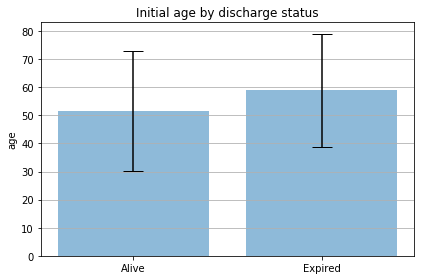

In [254]:
# For continuous features
# Merging mortality with apache
apache_merged = mortality.merge(apache, on='patientunitstayid')
apache_merged.head()
# apache_merged.groupby(['hospitaldischargestatus', 'gender']).count()['patientunitstayid'].plot(kind='bar')

feature = 'age'

grouped = apache_merged.groupby(['hospitaldischargestatus'])[['hospitaldischargestatus',feature]]

print(grouped.head())

alive = np.asarray(grouped.get_group('Alive')[feature].dropna())
exp = np.asarray(grouped.get_group('Expired')[feature].dropna())

# Plotting boxplots for each discharge status
# fig1, ax1 = plt.subplots()
# ax1.set_title('Creatinine')
# plt.boxplot([alive, exp])

alive_mean = np.mean(alive)
alive_std = np.std(alive)
exp_mean = np.mean(exp)
exp_std = np.std(exp)

print('num alive: ' + str(len(alive)))
print('num expired: ' + str(len(exp)))

# Create lists for the plot
materials = ['Alive', 'Expired']
x_pos = np.arange(2)
CTEs = [alive_mean, exp_mean]
error = [alive_std, exp_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(feature)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Initial ' + feature + ' by discharge status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
# exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

# print(alive_prop)
# print(exp_prop)

# # Plotting
# n_groups = 2
# alive_dist = tuple(alive_prop)
# exp_dist = tuple(exp_prop)

# # create plot
# fig, ax = plt.subplots()
# index = np.arange(n_groups)
# bar_width = 0.35
# opacity = 0.8

# rects1 = plt.bar(index, alive_dist, bar_width,
# alpha=opacity,
# color='skyblue',
# label='Alive')

# rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
# alpha=opacity,
# color='slategray',
# label='Expired')

# plt.xlabel('Discharge Status')
# plt.ylabel('Proportion of Patients By Gender')
# plt.title('Discharge Status Distributions By Gender')
# plt.xticks(index + bar_width, ('Male', 'Female'))
# plt.legend()

# # plt.savefig('gender_gcs_distrib.png')

# plt.tight_layout()
# plt.show()

## Nursecharting

In [7]:
# Looking at nursecharting

nursecharting.head()

# Defining amount of time in first window (in minutes)
first_time_len = 60*24

# Dropping all measurements at time points greater than this window
indexNames = nursecharting[nursecharting['nursingchartoffset'] > first_time_len].index
# Delete these row indexes from dataFrame
nursecharting_filt = nursecharting.drop(indexNames , inplace=False)
# # Deleting negative time measurements
indexNames = nursecharting[nursecharting['nursingchartoffset'] < 0].index
nursecharting_filt = nursecharting_filt.drop(indexNames , inplace=False)

In [285]:
nursecharting_types = nursecharting['nursingchartcelltypevalname'].drop_duplicates()
print(nursecharting_types)

0              Invasive BP Diastolic
4          Non-Invasive BP Diastolic
8               Non-Invasive BP Mean
12                  Respiratory Rate
16                  Invasive BP Mean
20                   Temperature (F)
24                             Value
36                               CVP
40              Invasive BP Systolic
44                        Heart Rate
48                               CPP
72                   Temperature (C)
76                     End Tidal CO2
104         Non-Invasive BP Systolic
184                              ICP
916             Temperature Location
99172                         Verbal
99180                          Motor
99188                           Eyes
99196                      GCS Total
145102                Sedation Scale
145104                        O2 L/%
145110                 O2 Saturation
145116                     Pain Goal
145128                Sedation Score
145152               O2 Admin Device
145202                Delirium Score
1

hospitaldischargestatus  nursingchartvalue
Alive                    10                    175
                         11                     96
                         12                     65
                         13                    185
                         14                    546
                         15                   1504
                         3                      63
                         4                      18
                         5                      18
                         6                      94
                         7                     129
                         8                      94
                         9                      95
Expired                  10                     20
                         11                      6
                         12                      5
                         13                     17
                         14                     24
                         15            

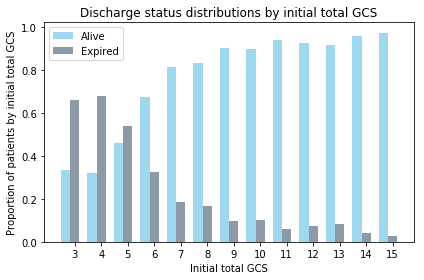

In [9]:
# Total GCS
tot_gcs = nursecharting_filt[nursecharting_filt['nursingchartcelltypevalname'] == 'GCS Total']
init_tot_gcs = tot_gcs.groupby('patientunitstayid').first()
# init_tot_gcs = tot_gcs.groupby('patientunitstayid').mean()

init_tot_gcs.head()

# Joining with mortality
grouped = mortality.merge(init_tot_gcs, on='patientunitstayid').groupby(['hospitaldischargestatus', 'nursingchartvalue']).count()['patientunitstayid'].drop('Unable to score due to medication', level=1)
print(grouped)

gcs_type = 'total'

alive_temp = list(grouped['Alive'])
exp_temp = list(grouped['Expired'])

alive = alive_temp[6:] + alive_temp[:6]
exp = exp_temp[6:] + exp_temp[:6]

print(alive)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = 13
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Initial ' + gcs_type + ' GCS')
plt.ylabel('Proportion of patients by initial ' + gcs_type + ' GCS')
plt.title('Discharge status distributions by initial ' + gcs_type + ' GCS')
plt.xticks(index + bar_width, tuple(list(range(3,15+1))))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

hospitaldischargestatus  nursingchartvalue
Alive                    1                     608
                         2                      54
                         3                      79
                         4                     475
                         5                    1415
Expired                  1                     268
                         2                       8
                         3                       7
                         4                      35
                         5                      43
Name: patientunitstayid, dtype: int64
[608, 54, 79, 475, 1415]
[268, 8, 7, 35, 43]
[0.6940639269406392, 0.8709677419354839, 0.9186046511627907, 0.9313725490196079, 0.9705075445816187]
[0.3059360730593607, 0.12903225806451613, 0.08139534883720931, 0.06862745098039216, 0.029492455418381344]


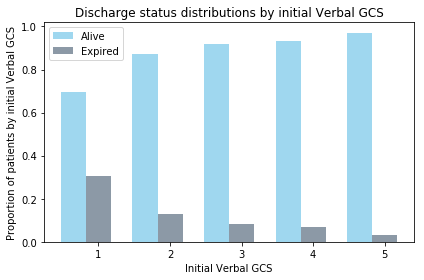

In [15]:
# Motor, Eyes, Verbal GCS

gcs_type = 'Verbal'
gcs_min = 1
gcs_max = 5

tot_gcs = nursecharting_filt[nursecharting_filt['nursingchartcelltypevalname'] == gcs_type]
init_tot_gcs = tot_gcs.groupby('patientunitstayid').first()
# init_tot_gcs = tot_gcs.groupby('patientunitstayid').mean()

init_tot_gcs.head()

# Joining with mortality
grouped = mortality.merge(init_tot_gcs, on='patientunitstayid').groupby(['hospitaldischargestatus', 'nursingchartvalue']).count()['patientunitstayid'].drop('Unable to score due to medication', level=1)
print(grouped)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])

print(alive)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = gcs_max-gcs_min+1
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Initial ' + gcs_type + ' GCS')
plt.ylabel('Proportion of patients by initial ' + gcs_type + ' GCS')
plt.title('Discharge status distributions by initial ' + gcs_type + ' GCS')
plt.xticks(index + bar_width, tuple(list(range(gcs_min,gcs_max+1))))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

Unnamed: 0                       int64
patientunitstayid                int64
diagnosisstring                 object
nursingchartid                   int64
patientunitstayid.1              int64
nursingchartoffset               int64
nursingchartentryoffset          int64
nursingchartcelltypecat         object
nursingchartcelltypevallabel    object
nursingchartcelltypevalname     object
nursingchartvalue                int32
dtype: object
     patientunitstayid hospitaldischargestatus     Unnamed: 0  nursingchartid  \
0               976143                   Alive  716837.880000    5.767351e+08   
1              1823818                   Alive  382626.000000    1.292404e+09   
2              1015921                   Alive  394098.521739    6.128709e+08   
3              2228330                   Alive  649067.000000    1.431113e+09   
4              3073401                   Alive  399210.370690    2.042692e+09   
17             3110965                 Expired  435700.000000    2.0328

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


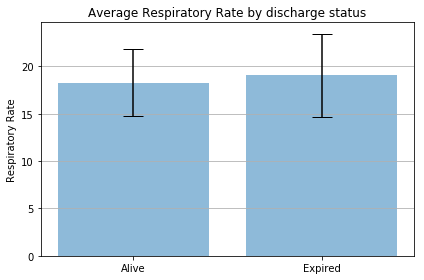

In [328]:
# Respiratory rate
feature = 'Respiratory Rate'

tot_gcs = nursecharting_filt[nursecharting_filt['nursingchartcelltypevalname'] == feature]
tot_gcs['nursingchartvalue'] = tot_gcs['nursingchartvalue'].astype(str).astype(int)
print(tot_gcs.dtypes)
# init_tot_gcs = tot_gcs.groupby('patientunitstayid').first()
init_tot_gcs = tot_gcs.groupby('patientunitstayid').mean()

init_tot_gcs.head()

# Joining with mortality
grouped = mortality.merge(init_tot_gcs, on='patientunitstayid').groupby(['hospitaldischargestatus'])

print(grouped.head())

alive = np.asarray(grouped.get_group('Alive')['nursingchartvalue'].dropna())
exp = np.asarray(grouped.get_group('Expired')['nursingchartvalue'].dropna())

alive_mean = np.mean(alive)
alive_std = np.std(alive)
exp_mean = np.mean(exp)
exp_std = np.std(exp)

print('num alive: ' + str(len(alive)))
print('num expired: ' + str(len(exp)))

# Create lists for the plot
materials = ['Alive', 'Expired']
x_pos = np.arange(2)
CTEs = [alive_mean, exp_mean]
error = [alive_std, exp_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(feature)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Average ' + feature + ' by discharge status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## Respiratory Data - indicator variables

In [3]:
# Looking at respiration

print(respiratory.head())

# Defining amount of time in first window (in minutes)
first_time_len = 60*24

respiratory_types = respiratory[respiratory['respcharttypecat'] == 'respFlowPtVentData']['respchartvaluelabel'].drop_duplicates()
print(respiratory_types)

# Dropping all measurements at time points greater than this window
indexNames = respiratory[respiratory['respchartoffset'] > first_time_len].index
# Delete these row indexes from dataFrame
respiratory_filt = respiratory.drop(indexNames , inplace=False)
# Deleting negative time measurements
indexNames = respiratory[respiratory['respchartoffset'] < 0].index
respiratory_filt = respiratory_filt.drop(indexNames , inplace=False)

   Unnamed: 0  respchartid  patientunitstayid  respchartoffset  \
0           0    188502297            2747640           125122   
1           1    188502296            2747640           125122   
2           2    188502294            2747640           125122   
3           3    183611567            2747640           332279   
4           4    183611566            2747640           332279   

   respchartentryoffset    respcharttypecat    respchartvaluelabel  \
0                125123    respFlowSettings              TV/kg IBW   
1                125123    respFlowSettings     Tidal Volume (set)   
2                125123    respFlowSettings                   FiO2   
3                332280    respFlowCareData  Head of Bed Elevation   
4                332280  respFlowPtVentData                   SaO2   

  respchartvalue  diagnosisid  patientunitstayid.1  activeupondischarge  \
0         7.9811     32146310              2747640                False   
1            400     32146310   

hospitaldischargestatus  was_measured
Alive                    0               4149
                         1                819
Expired                  0                552
                         1                313
Name: patientunitstayid, dtype: int64
[4149, 819]
[552, 313]
[0.8825781748564135, 0.7234982332155477]
[0.11742182514358647, 0.2765017667844523]


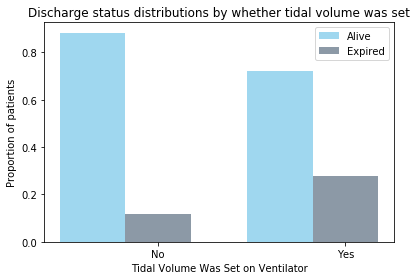

In [11]:
# Getting patients that have tidal volume set

feature = 'Tidal Volume (set)'
tidal_vol_patients = pd.DataFrame(respiratory_filt[respiratory_filt['respchartvaluelabel'] == feature]['patientunitstayid'].drop_duplicates())

tidal_vol_patient_data = tidal_vol_patients.merge(mortality, on='patientunitstayid')
tidal_vol_patient_data['was_measured'] = 1

non_tidal_vol_patients = patients[~patients.isin(tidal_vol_patients.all(1))]

non_tidal_vol_patient_data = non_tidal_vol_patients.merge(mortality, on='patientunitstayid')
non_tidal_vol_patient_data['was_measured'] = 0

all_tidal_vol = pd.concat([
    tidal_vol_patient_data,non_tidal_vol_patient_data
],ignore_index=True)

# Joining with mortality
grouped = all_tidal_vol.groupby(['hospitaldischargestatus', 'was_measured']).count()['patientunitstayid']
print(grouped)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])

print(alive)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = 2
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Tidal Volume Was Set on Ventilator')
plt.ylabel('Proportion of patients')
plt.title('Discharge status distributions by whether tidal volume was set')
plt.xticks(index + bar_width, tuple(['No', 'Yes']))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

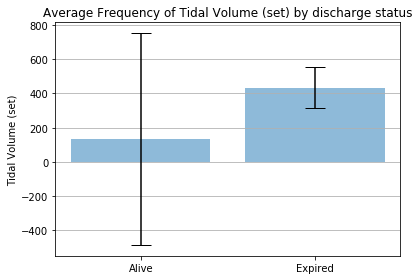

In [41]:
# Getting frequency of measurements for each patient
all_tidal_vol.head()

# Get tidal volume data
tidal_vol_meas = pd.DataFrame(respiratory_filt[respiratory_filt['respchartvaluelabel'] == feature])#['patientunitstayid']
tidal_vol_meas.head()

tidal_vol_grouped = tidal_vol_meas.groupby('patientunitstayid').count()
frequencies = pd.DataFrame(tidal_vol_grouped['respchartoffset'])
frequencies.head()

tidal_vol_patient_frequencies = frequencies.merge(tidal_vol_patients, on='patientunitstayid')
tidal_vol_patient_frequencies = tidal_vol_patient_frequencies.rename(columns={"respchartoffset": "freq"})
tidal_vol_patient_frequencies.head()

non_freqs = [0]*(non_tidal_vol_patients.shape[0])
non_tidal_vol_patient = non_tidal_vol_patients
non_tidal_vol_patient['freq'] = non_freqs

non_tidal_vol_patient.head()

# all_data = pd.concat([tidal_vol_patient_frequencies, non_tidal_vol_patient])
all_data = tidal_vol_patient_frequencies
all_data.head()

# Getting mortality
all_data_mortality = mortality.merge(all_data, on='patientunitstayid')

all_data_mortality.head()

alive = list(all_data_mortality[all_data_mortality['hospitaldischargestatus'] == 'Alive']['freq'])
expired = list(all_data_mortality[all_data_mortality['hospitaldischargestatus'] == 'Expired']['freq'])

alive_mean = np.mean(alive)
alive_std = np.std(alive)
exp_mean = np.mean(exp)
exp_std = np.std(exp)

# Create lists for the plot
materials = ['Alive', 'Expired']
x_pos = np.arange(2)
CTEs = [alive_mean, exp_mean]
error = [alive_std, exp_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(feature)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Average Frequency of ' + feature + ' by discharge status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

hospitaldischargestatus  was_measured
Alive                    0               4149
                         1               2152
Expired                  0                552
                         1                437
Name: patientunitstayid, dtype: int64
[4149, 2152]
[552, 437]
[0.8825781748564135, 0.8312089609887988]
[0.11742182514358647, 0.16879103901120124]


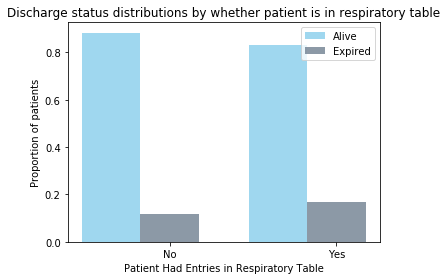

In [13]:
# Getting all patients in respiratory table

tidal_vol_patients = pd.DataFrame(respiratory_filt['patientunitstayid'].drop_duplicates())

tidal_vol_patient_data = tidal_vol_patients.merge(mortality, on='patientunitstayid')
tidal_vol_patient_data['was_measured'] = 1

non_tidal_vol_patients = patients[~patients.isin(tidal_vol_patients.all(1))]

non_tidal_vol_patient_data = non_tidal_vol_patients.merge(mortality, on='patientunitstayid')
non_tidal_vol_patient_data['was_measured'] = 0

all_tidal_vol = pd.concat([
    tidal_vol_patient_data,non_tidal_vol_patient_data
],ignore_index=True)

# Joining with mortality
grouped = all_tidal_vol.groupby(['hospitaldischargestatus', 'was_measured']).count()['patientunitstayid']
print(grouped)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])

print(alive)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = 2
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Patient Had Entries in Respiratory Table')
plt.ylabel('Proportion of patients')
plt.title('Discharge status distributions by whether patient is in respiratory table')
plt.xticks(index + bar_width, tuple(['No', 'Yes']))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

## Lab Data

In [36]:
print(lab.head())

lab_feats = list(lab['labname'].drop_duplicates())
for f in lab_feats:
    print(f)

# Defining amount of time in first window (in minutes)
first_time_len = 60*24

# Dropping all measurements at time points greater than this window
indexNames = lab[lab['labresultoffset'] > first_time_len].index
# Delete these row indexes from dataFrame
lab_filt = lab.drop(indexNames , inplace=False)
# Deleting negative time measurements
indexNames = lab[lab['labresultoffset'] < 0].index
lab_filt = lab_filt.drop(indexNames , inplace=False)

   Unnamed: 0  patientunitstayid  \
0           0             976143   
1           1             976143   
2           2             976143   
3           3             976143   
4           4             976143   

                                     diagnosisstring      labid  \
0  burns/trauma|trauma - CNS|spinal cord injury|c...  228078093   
1  burns/trauma|trauma - CNS|spinal cord injury|c...  229470282   
2  burns/trauma|trauma - CNS|spinal cord injury|c...  231416160   
3  burns/trauma|trauma - CNS|spinal cord injury|c...  231286752   
4  burns/trauma|trauma - CNS|spinal cord injury|c...  228934761   

   patientunitstayid.1  labresultoffset  labtypeid          labname  \
0               976143             1552        1.0          albumin   
1               976143             1552        3.0              Hct   
2               976143             1781        4.0  bedside glucose   
3               976143             1866        4.0  bedside glucose   
4               976143   

hospitaldischargestatus  was_measured
Alive                    0               4149
                         1               3963
Expired                  0                552
                         1                510
Name: patientunitstayid, dtype: int64
[4149, 3963]
[552, 510]
[0.8825781748564135, 0.8859825620389]
[0.11742182514358647, 0.11401743796109994]


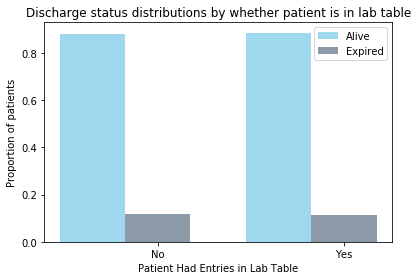

In [21]:
# Finding all patients that have entries in lab results table
lab_patients = pd.DataFrame(lab_filt['patientunitstayid'].drop_duplicates()).merge(patients, on='patientunitstayid')


lab_patient_data = lab_patients.merge(mortality, on='patientunitstayid')
lab_patient_data['was_measured'] = 1

non_lab_patients = patients[~patients.isin(lab_patients.all(1))]

non_lab_patient_data = non_lab_patients.merge(mortality, on='patientunitstayid')
non_lab_patient_data['was_measured'] = 0

all_lab = pd.concat([
    lab_patient_data,non_lab_patient_data
],ignore_index=True)

# Joining with mortality
grouped = all_lab.groupby(['hospitaldischargestatus', 'was_measured']).count()['patientunitstayid']
print(grouped)

alive = list(grouped['Alive'])
exp = list(grouped['Expired'])

print(alive)
print(exp)
tots = [alive[i] + exp[i] for i in range(len(alive))]

alive_prop = [alive[i] / tots[i] for i in range(len(alive))]
exp_prop = [exp[i] / tots[i] for i in range(len(alive))]

print(alive_prop)
print(exp_prop)

# Plotting
n_groups = 2
alive_dist = tuple(alive_prop)
exp_dist = tuple(exp_prop)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, alive_dist, bar_width,
alpha=opacity,
color='skyblue',
label='Alive')

rects2 = plt.bar(index + bar_width, exp_dist, bar_width,
alpha=opacity,
color='slategray',
label='Expired')

plt.xlabel('Patient Had Entries in Lab Table')
plt.ylabel('Proportion of patients')
plt.title('Discharge status distributions by whether patient is in lab table')
plt.xticks(index + bar_width, tuple(['No', 'Yes']))
plt.legend()

# plt.savefig('gender_gcs_distrib.png')

plt.tight_layout()
plt.show()

Unnamed: 0                   int64
patientunitstayid            int64
diagnosisstring             object
labid                        int64
patientunitstayid.1          int64
labresultoffset              int64
labtypeid                  float64
labname                     object
labresult                  float64
labresulttext               object
labmeasurenamesystem        object
labmeasurenameinterface     object
labresultrevisedoffset       int64
dtype: object
     patientunitstayid hospitaldischargestatus     Unnamed: 0         labid  \
0              1823818                   Alive     664.000000  4.349590e+08   
1              1015921                   Alive     579.000000  2.409660e+08   
2              2228330                   Alive  375540.750000  5.073135e+08   
3              3073401                   Alive  302948.750000  7.511527e+08   
4              3199652                   Alive  353457.000000  7.838681e+08   
13             3110965                 Expired  309708.50

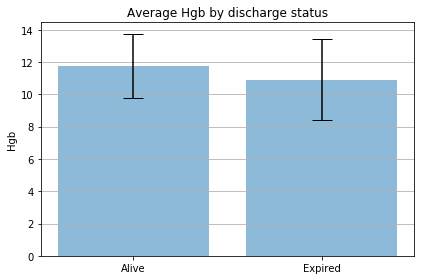

In [50]:
# Lab Proportions
feature = 'Hgb'

val = lab_filt[lab_filt['labname'] == feature]
print(val.dtypes)
# init_tot_gcs = tot_gcs.groupby('patientunitstayid').first()
init_val = val.groupby('patientunitstayid').mean()

init_val.head()

# Joining with mortality
grouped = mortality.merge(init_val, on='patientunitstayid').groupby(['hospitaldischargestatus'])

print(grouped.head())

alive = np.asarray(grouped.get_group('Alive')['labresult'].dropna())
exp = np.asarray(grouped.get_group('Expired')['labresult'].dropna())

alive_mean = np.mean(alive)
alive_std = np.std(alive)
exp_mean = np.mean(exp)
exp_std = np.std(exp)

print('num alive: ' + str(len(alive)))
print('num expired: ' + str(len(exp)))

# Create lists for the plot
materials = ['Alive', 'Expired']
x_pos = np.arange(2)
CTEs = [alive_mean, exp_mean]
error = [alive_std, exp_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(feature)
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Average ' + feature + ' by discharge status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()